# 读取数据的类

In [4]:
from datetime import datetime
import pymongo
import pandas as pd

# get data dict, key(symbol):values(dataframe)
class mongodbCryptoData(object):
    # get data form mongodb
    def __init__(self, symbolList, dataDict, start, end=datetime.now(), rule='H'):
        self.symbolList = symbolList
        self.dataDict = dataDict
        self.rule = rule
        self.start = start
        self.end = end
        self.rule = rule

    def _readAll(self, collection):
        return pd.DataFrame(
            list(collection.find({"datetime": {'$gt': self.start, '$lt': self.end}}))
        )

    def getSymbols(self):
        for s in self.symbolList:
            self.dataDict.update({s: self._readAll(self.dataDict[s])})

    def _resampleCandle(self, df, rule):
        df = df.set_index('datetime')
        if rule=='1min':
            return df
        resampled = df.resample(rule, label='right').agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
        return resampled

    def getSymbolsData(self):
        for s in self.symbolList:
            self.dataDict.update({s: self._resampleCandle(self.dataDict[s], self.rule)})
        
    def runDataDict(self):
        self.getSymbols()
        self.getSymbolsData()
        return self.dataDict

In [5]:
# 设置数据库信息处理数据

In [10]:
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import warnings

warnings.filterwarnings('ignore')
# Data Config
client = pymongo.MongoClient('localhost', 27017)
db_names = client.list_database_names()
print(db_names)
symbolList = ['btc_usd_cq.future:okex', 'eos_usd_cq.future:okex']
dataDict = { s: client['Kline_1Min_Auto_Db_Plus'][s] for s in symbolList}
start = datetime(2019,11,20)
end = datetime(2020, 1, 20)
rule = '1min'

mongodbData = mongodbCryptoData(symbolList, dataDict, start, end, rule)
dataDict = mongodbData.runDataDict()
print(dataDict)
btcData = dataDict['btc_usd_cq.future:okex']
eosData = dataDict['eos_usd_cq.future:okex']

coinDf = pd.concat([btcData.close, eosData.close], keys=['btcClose', 'eosClose'], axis=1)


['Kline_1Min_Auto_Db_Plus', 'VnTrader_15Min_Db_Coin', 'VnTrader_1Min_Db_Case', 'VnTrader_1Min_Db_Coin', 'VnTrader_30Min_Db_Coin', 'VnTrader_5Min_Db_Coin', 'VnTrader_60Min_Db_Coin', 'admin', 'config', 'local']
{'btc_usd_cq.future:okex':                                           _id    close      date     high  \
datetime                                                                    
2019-11-20 00:01:00  5e38f289e35e9f0af893bef6  8179.22  20191120  8179.23   
2019-11-20 00:02:00  5e38f289e35e9f0af893bef8  8206.00  20191120  8210.64   
2019-11-20 00:03:00  5e38f289e35e9f0af893befa  8190.08  20191120  8208.02   
2019-11-20 00:04:00  5e38f289e35e9f0af893befc  8189.08  20191120  8196.60   
2019-11-20 00:05:00  5e38f289e35e9f0af893befe  8187.02  20191120  8189.50   
...                                       ...      ...       ...      ...   
2020-01-19 23:55:00  5e38f2dbe35e9f0af8966d36  8780.37  20200119  8782.64   
2020-01-19 23:56:00  5e38f2dbe35e9f0af8966d38  8775.63  20200119  8780.

## indicator and signal

BOLLINGER BAND DIVERGENCE(from Intermarket Trading Strategies Page 123)：

$BollingerBBottom=MA−2SD$
$BollingerBTop=MA+2SD$

$SEC1BOL=(C-BollingerBBottom)/(BollingerBTop-BollingerBBottom)$

SEC1BOL=1+(C-MA+2SD)/4SD

DIVERGENCE=EMA(3)[(SEC2BOL−SEC1BOL)/SEC1BOL ∗ 100]


Exit: holdBarCount

In [7]:
class Bollinger_divergence(object):
    def __init__(self, coinDf, paraDict):
        self.paraDict = paraDict
        self.coinDf = coinDf.dropna()
        self.maPeriod = paraDict['maPeriod']
        self.divergenceThreshold = paraDict['divergenceThreshold']
        self.holdBarCount = paraDict['holdBarCount']
        self.sharpeRatio = 0
        
    def get_EMA(self,data, days):
        emas = data.copy()   
        for i in range(len(data)):
            if i == 0:
                emas[i] = data[i]
            if i > 0:
                emas[i] = ((days - 1) * emas[i - 1] + 2 * data[i]) / (days + 1)
        return emas

    
    def idIndicator(self):
        btcMa = self.coinDf['btcClose'].rolling(self.maPeriod).mean()
        eosMa = self.coinDf['eosClose'].rolling(self.maPeriod).mean()
        btcSd = self.coinDf['btcClose'].rolling(self.maPeriod).std()
        eosSd = self.coinDf['eosClose'].rolling(self.maPeriod).std()
        
        btc_BollingerBBottom = btcMa - 2*btcSd
        btc_BollingerBTop = btcMa + 2*btcSd
        eos_BollingerBBottom = eosMa - 2*eosSd
        eos_BollingerBTop = eosMa + 2*eosSd
        SEC1BOL = 1 + (self.coinDf['btcClose']-btcMa+2*btcSd)/(4*btcSd)
        SEC2BOL = 1 + (self.coinDf['eosClose']-eosMa+2*eosSd)/(4*eosSd)      
        DIVERGENCE = [(SEC2BOL-SEC1BOL)/SEC1BOL* 100]         
        EMA_DIVERGENCE = self.get_EMA(DIVERGENCE,3)
        EMA_DIVERGENCE = np.transpose(EMA_DIVERGENCE)
        self.coinDf['EMA_DIVERGENCE'] = EMA_DIVERGENCE
        print(EMA_DIVERGENCE)
        self.coinDf['EMA_DIVERGENCE'] = self.coinDf['EMA_DIVERGENCE'][:-3]
        
    def twoSymbolChart(self):
        coinArray = self.coinDf.T.values
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10))
        ax1.plot(coinArray[0],'r')
        ax1.grid(True)
        ax1.legend(['btc'],loc =2)
        ax2 = ax1.twinx()  #双坐标
        ax2.plot(coinArray[1])
        ax2.legend(['eos'],loc = 4)
        ax3.plot(coinArray[2])
        if not os.path.isdir('./idBtcEosChart'):
            os.mkdir('./idBtcEosChart')
            plt.savefig('./idBtcEosChart/Ma%s_Cor%s.jpg'%(self.maPeriod, self.divergenceThreshold))
        else:
            plt.savefig('./idBtcEosChart/Ma%s_Cor%s.jpg'%(self.maPeriod, self.divergenceThreshold))
        
    def calSignals(self):
        coinArray = self.coinDf.T.values
        eos_coinArray = coinArray[1]
        coinNowL = coinArray[2][1:]
        coinNowR = coinArray[2][:-1]
        coinShift = coinArray[2][:-1]
        coinForward = coinArray[2][1:]
  
        Short = np.where((coinNowL<-self.divergenceThreshold) & (coinNowL<coinShift)& (coinForward>coinNowR) , 1, 0)
        Buy = np.where((coinNowL>self.divergenceThreshold)  & (coinForward<coinNowR) , 1, 0)
        #& (coinForward>coinNowR)
        #& (coinForward<coinNowR)
        buyPoint = np.where(Buy>0)
        shortPoint = np.where(Short>0)
        print(buyPoint)
        buyPrice = coinArray[1][1:][buyPoint]
        sellPrice = coinArray[1][1:][buyPoint[0]+self.holdBarCount]
        shortPrice = coinArray[1][1:][shortPoint]
        coverPrice = coinArray[1][1:][shortPoint[0]+self.holdBarCount]

        zipBuy = zip(buyPoint[0] , (sellPrice - buyPrice))
        zipShort = zip(shortPoint[0], (shortPrice - coverPrice ))
        return zipBuy, zipShort
    
    def perfPlotSave(self, zipBuy, zipShort):
        
        coinArray = self.coinDf.T.values
        perfResult = sorted(itertools.chain(zipBuy, zipShort), key= lambda item: item[0])
        
        perfIndex = np.array(perfResult, dtype=int).T[0, :]
        perOrderValue = np.array(perfResult).T[1, :]

        priceEos = coinArray[1][1:][perfIndex]
        perfReturn = perOrderValue/priceEos
        sharpeRatio = perfReturn.mean()/perfReturn.std()*np.sqrt(240)
        perfSum = perOrderValue.cumsum()
        fig, ax4 = plt.subplots(1, 1, figsize=(15, 7))
        ax4.plot(perfSum)
        if not os.path.isdir('./idBtcEosPerf'):
            os.mkdir('./idBtcEosPerf')
            plt.savefig('./idBtcEosPerf/Ma%s_TH%s_HBC%s.jpg'\
                %(self.maPeriod, self.divergenceThreshold, self.holdBarCount))
        else:
            plt.savefig('./idBtcEosPerf/Ma%s_TH%s_HBC%s.jpg'\
                %(self.maPeriod, self.divergenceThreshold, self.holdBarCount))
        self.paraDict.update({'sharpeRatio': round(sharpeRatio,3),\
                              'orderTime':len(perfResult)})
        
    def runSignalTest(self):
        self.idIndicator()
        self.twoSymbolChart()
        zipBuy, zipShort = self.calSignals()
        resultDict = self.perfPlotSave(zipBuy, zipShort)
        return self.paraDict
    

[[        nan]
 [        nan]
 [        nan]
 ...
 [-6.48000141]
 [-4.03051642]
 [-1.25614436]]
(array([  255,   259,   272, ..., 87358, 87360, 87362], dtype=int64),)


{'maPeriod': 160,
 'divergenceThreshold': 20,
 'holdBarCount': 60,
 'sharpeRatio': 1.825,
 'orderTime': 3943}

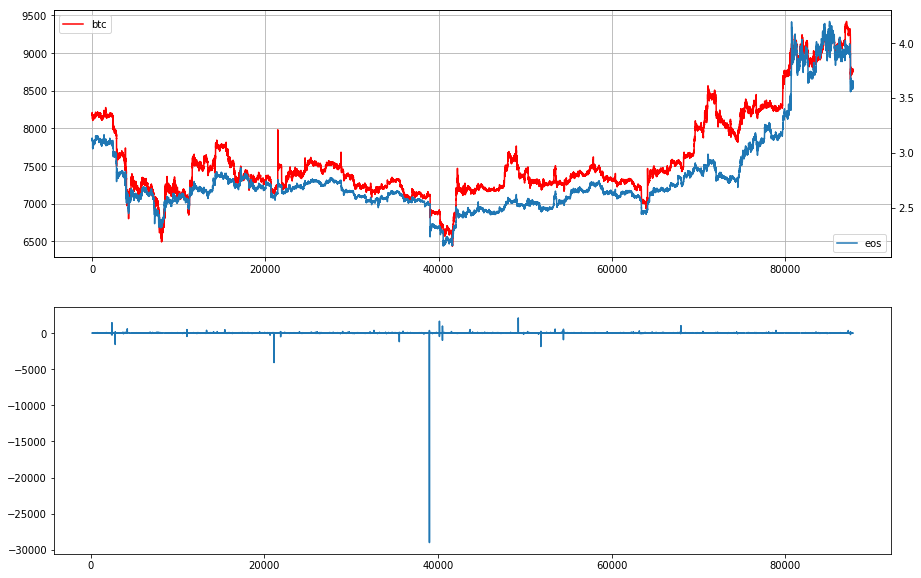

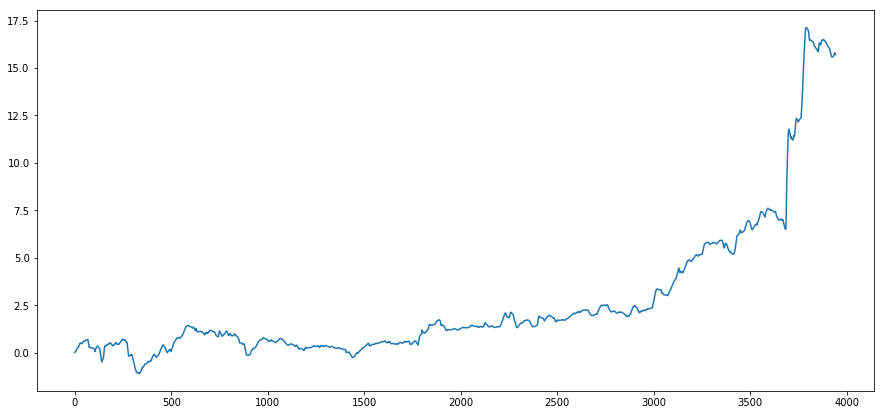

In [8]:
paraDict = {'maPeriod':160,  'divergenceThreshold':20, 'holdBarCount':60}
coinSig = Bollinger_divergence(coinDf, paraDict)
coinSig.runSignalTest()

## 参数优化

In [34]:
import numpy as np
from itertools import product

paramDict = {'maPeriod': range(140,161,2),  \
            'divergenceThreshold':np.arange(20, 31, 1),'holdBarCount': range(30, 61, 5)}

nameList = paramDict.keys()
paramList = paramDict.values()
# 使用迭代工具生产参数对组合
productList = list(product(*paramList))

# 把参数对组合打包到一个个字典组成的列表中
settingList = []
for p in productList:
    d = dict(zip(nameList, p))
    settingList.append(d)

print(settingList[-5:])

[{'maPeriod': 160, 'divergenceThreshold': 30, 'holdBarCount': 40}, {'maPeriod': 160, 'divergenceThreshold': 30, 'holdBarCount': 45}, {'maPeriod': 160, 'divergenceThreshold': 30, 'holdBarCount': 50}, {'maPeriod': 160, 'divergenceThreshold': 30, 'holdBarCount': 55}, {'maPeriod': 160, 'divergenceThreshold': 30, 'holdBarCount': 60}]


[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87355, 87358, 87360], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 20, 'holdBarCount': 30, 'sharpeRatio': 1.499, 'orderTime': 3847}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87355, 87358, 87360], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 20, 'holdBarCount': 35, 'sharpeRatio': 1.474, 'orderTime': 3847}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87355, 87358, 87360], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 20, 'holdBarCount': 40, 'sharpeRatio': 1.665, 'orderTime': 3847}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87355, 87358, 87360], dtype=int64

(array([  255,   259,   260, ..., 87288, 87291, 87355], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 24, 'holdBarCount': 40, 'sharpeRatio': 1.628, 'orderTime': 2715}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87288, 87291, 87355], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 24, 'holdBarCount': 45, 'sharpeRatio': 1.765, 'orderTime': 2715}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87288, 87291, 87355], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 24, 'holdBarCount': 50, 'sharpeRatio': 1.745, 'orderTime': 2715}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87288, 87291, 87355], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 24, 'holdBarCount': 55, 'sharpeRatio': 1.618,

(array([  255,   259,   260, ..., 87283, 87287, 87288], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 28, 'holdBarCount': 50, 'sharpeRatio': 1.843, 'orderTime': 1925}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87283, 87287, 87288], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 28, 'holdBarCount': 55, 'sharpeRatio': 1.779, 'orderTime': 1925}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87283, 87287, 87288], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 28, 'holdBarCount': 60, 'sharpeRatio': 1.685, 'orderTime': 1925}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  255,   259,   260, ..., 87282, 87283, 87287], dtype=int64),)
Done: {'maPeriod': 140, 'divergenceThreshold': 29, 'holdBarCount': 30, 'sharpeRatio': 1.771,

(array([  255,   259,   260, ..., 87292, 87355, 87358], dtype=int64),)
Done: {'maPeriod': 142, 'divergenceThreshold': 21, 'holdBarCount': 60, 'sharpeRatio': 1.793, 'orderTime': 3526}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.85159202]
 [-3.20832794]
 [ 0.44603375]]
(array([  255,   259,   260, ..., 87291, 87355, 87358], dtype=int64),)
Done: {'maPeriod': 142, 'divergenceThreshold': 22, 'holdBarCount': 30, 'sharpeRatio': 1.543, 'orderTime': 3235}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.85159202]
 [-3.20832794]
 [ 0.44603375]]
(array([  255,   259,   260, ..., 87291, 87355, 87358], dtype=int64),)
Done: {'maPeriod': 142, 'divergenceThreshold': 22, 'holdBarCount': 35, 'sharpeRatio': 1.504, 'orderTime': 3235}
[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.85159202]
 [-3.20832794]
 [ 0.44603375]]
(array([  255,   259,   260, ..., 87291, 87355, 87358], dtype=int64),)
Done: {'maPeriod': 142, 'divergenceThreshold': 22, 'holdBarCount': 40, 'sharpeRatio': 1.613,

KeyboardInterrupt: 

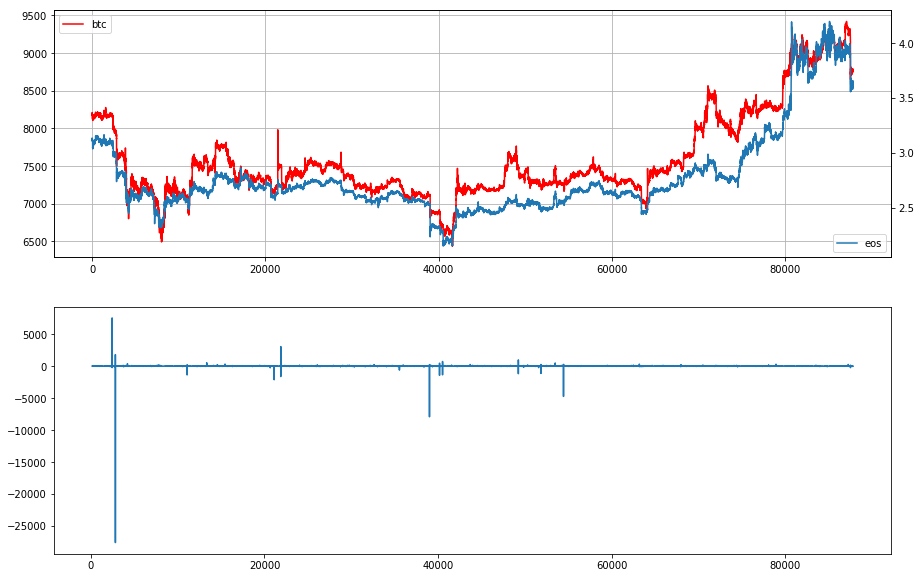

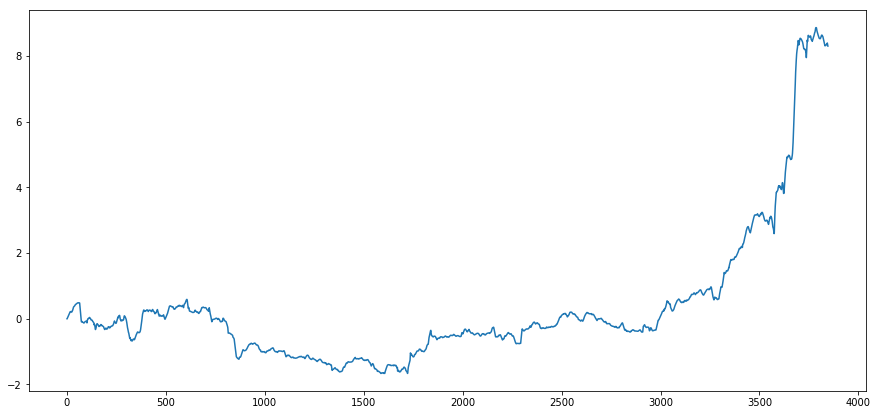

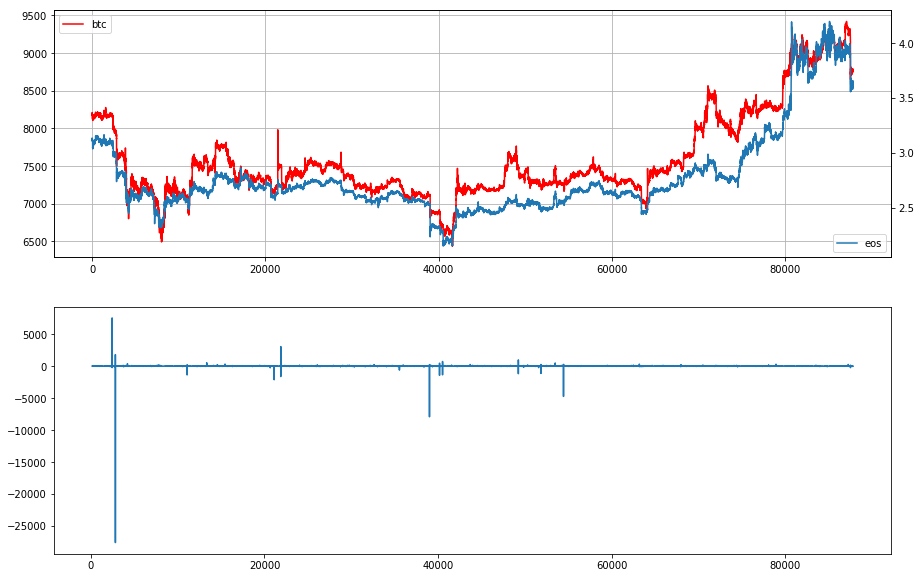

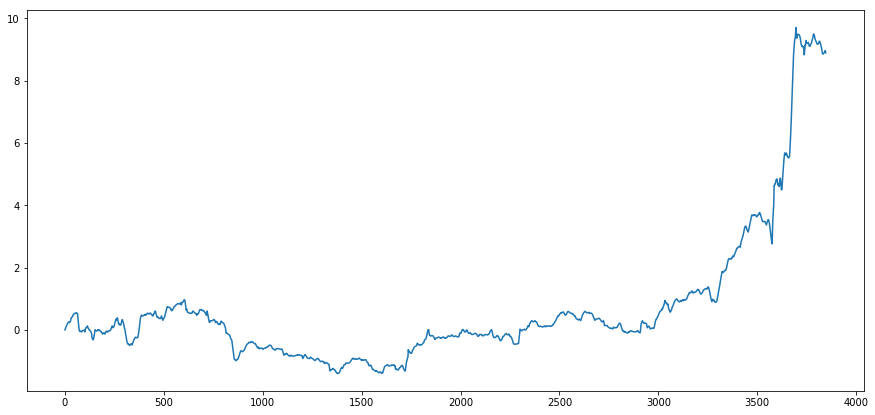

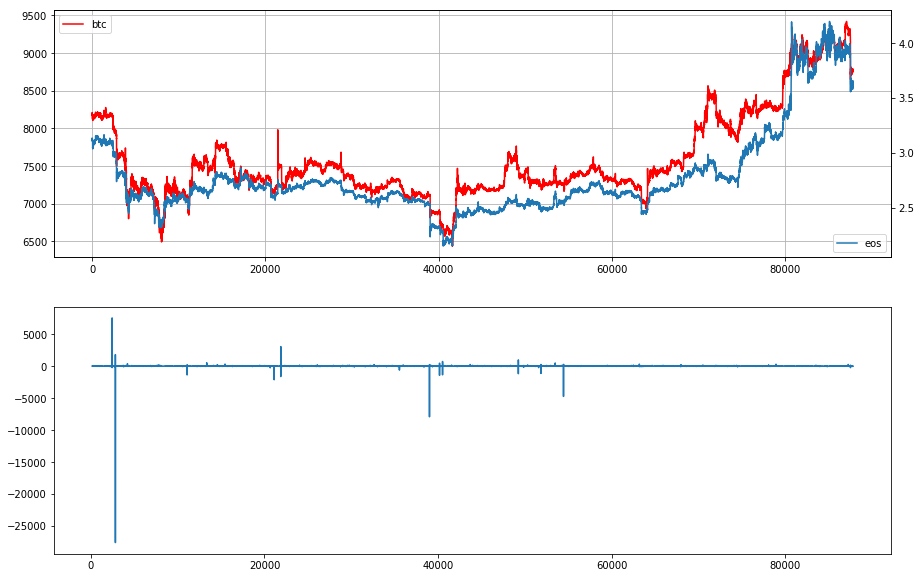

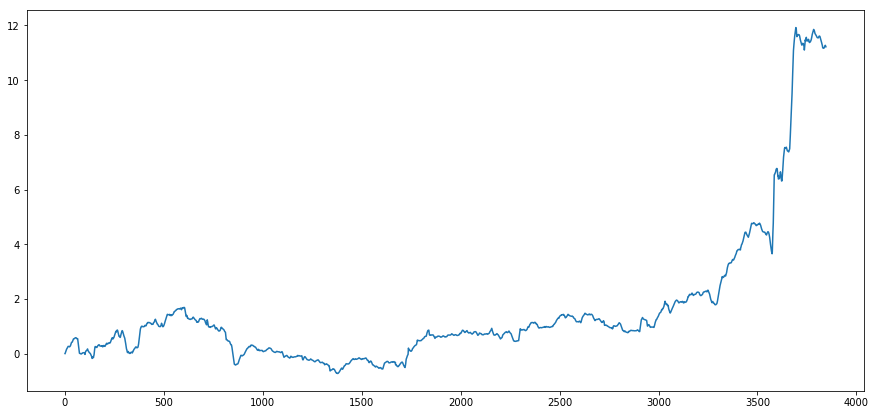

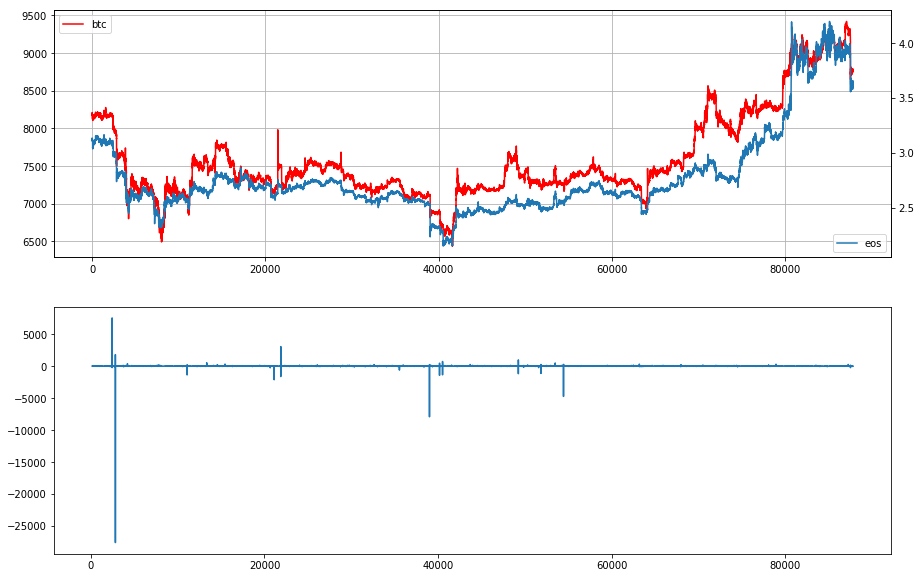

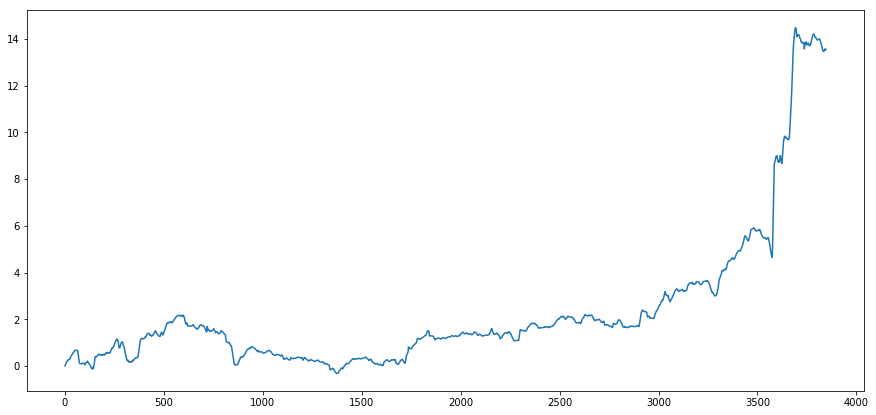

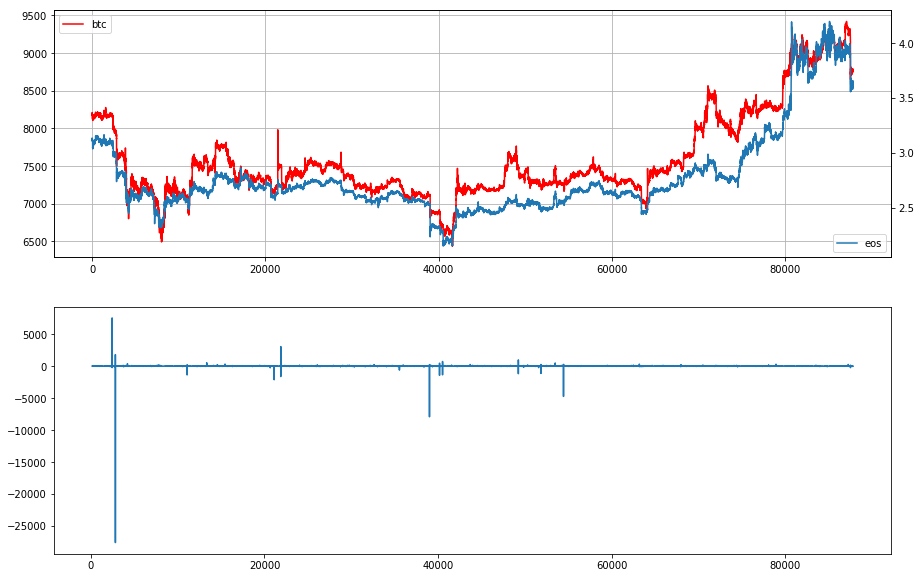

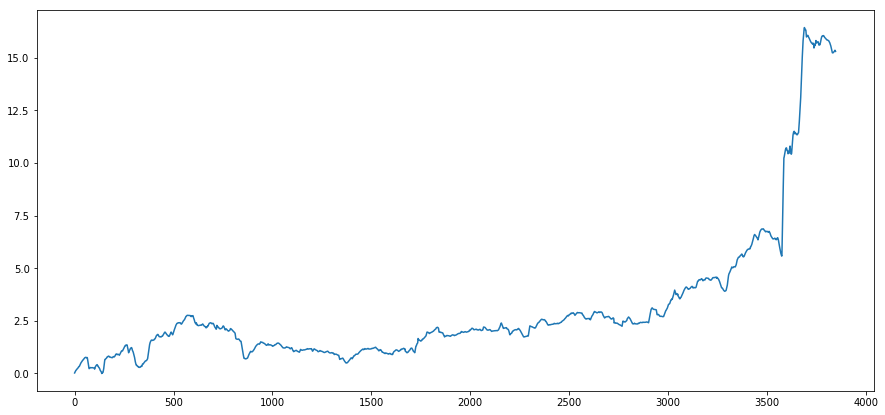

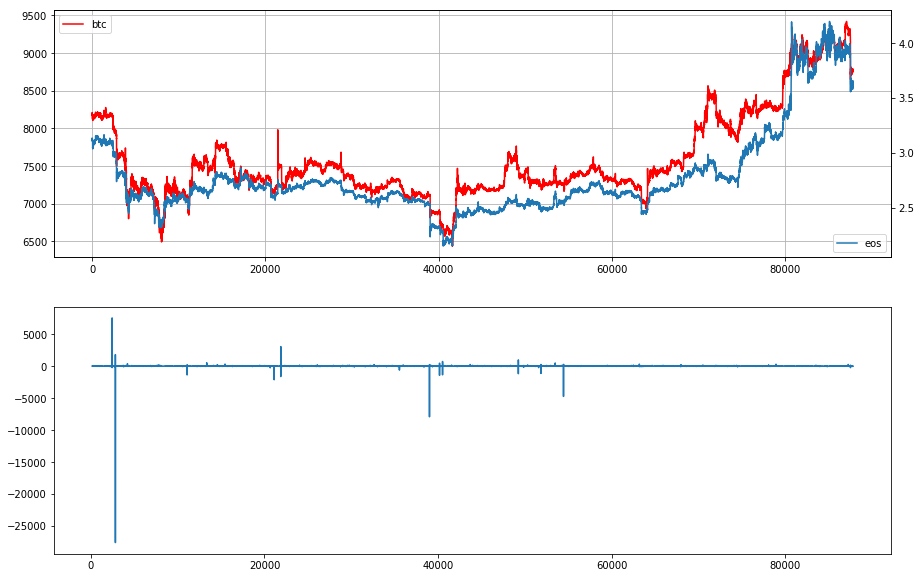

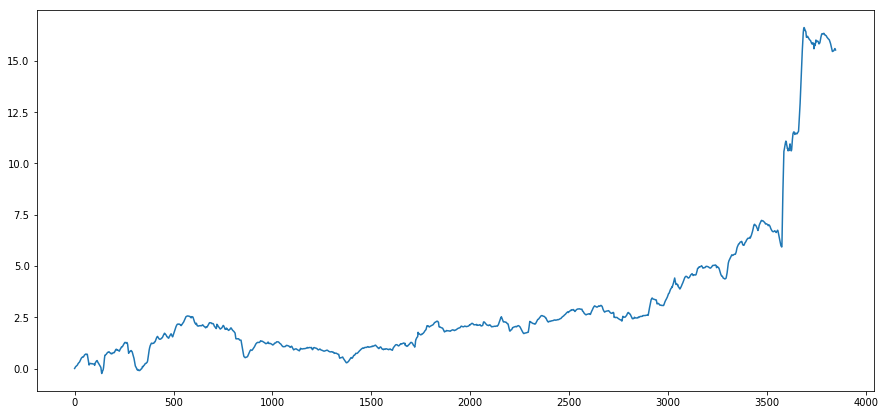

In [ ]:
paramResultList = []
for newParam in settingList:
    coinSig = Bollinger_divergence(coinDf, newParam)
    paramResult = coinSig.runSignalTest()
    paramResultList.append(paramResult)
    print('Done:', newParam)

In [ ]:
paramResultList_= pd.DataFrame(paramResultList)
print(paramResultList_)
result = paramResultList_.sort_values(by = ['sharpeRatio'], ascending=False)


In [29]:
resultOrder = result[(result.orderTime>20) & (result.sharpeRatio>0)]

In [30]:
resultOrder

,maPeriod,divergenceThreshold,holdBarCount,sharpeRatio,orderTime
5,160,20,60,1.825,3943
7,160,30,60,1.824,1686
3,140,30,60,1.774,1623
1,140,20,60,1.739,3847
2,140,30,30,1.721,1623
6,160,30,30,1.640,1686
0,140,20,30,1.499,3847
4,160,20,30,1.474,3943


In [33]:
resultOrder.to_excel('C:\\Users\\23503\\Desktop\\internshipStrategies\\date%s%s%s%s.xlsx'%(str(start.year),str(start.month),str(end.year),str(end.month)))